#**Training a mini-GPT**






We will train our own GPT using 1% of the 750 GB corpus that Google released in 2020 (C4 - Colossal Clean Crawled Corpus).

In [1]:
import keras
import pathlib

keras.utils.get_file(
    fname="mini-c4",
    origin="https://hf.co/datasets/mattdangerw/mini-c4/resolve/main/mini-c4.zip",
    extract=True,
)

extract_dir = "/root/.keras/datasets/mini-c4/mini-c4/"

1505674161/1505674161 ━━━━━━━━━━━━━━━━━━━━ 64s 0us/step


Now let's look at one of the files...

In [2]:
import os

print(os.listdir(extract_dir))

with open(extract_dir + "shard0.txt", "r") as f:
    print(f.readline().replace("\\n", "\n")[:100])

['shard4.txt', 'shard1.txt', 'shard0.txt', 'shard3.txt', 'shard2.txt']
Beginners BBQ Class Taking Place in Missoula!
Do you want to get better at making delicious BBQ? You


This is a really big text dataset, despite it's just 1% of the total. We will use a pre-written tokenizer from Keras Hub that's in C++ (hence, it's fast). This is a sub-word tokenizer, so it tokenizes words into integer indices based on character combinations.

In [4]:
import keras_hub
import numpy as np

# We are not learning the vocabulary from our text data.
# Instead, we are going to use a predefined vocabulary for sub-word tokens that works with 'SentencePiece' - the tokenizer we will use.
vocabulary_file = keras.utils.get_file(
    origin="https://hf.co/mattdangerw/spiece/resolve/main/vocabulary.proto",
)

tokenizer = keras_hub.tokenizers.SentencePieceTokenizer(vocabulary_file)

499723/499723 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We can go back and forth from integers to text pretty easily with this tokenizer. It has a function built into it for decoding integers.

In [6]:
print(tokenizer.tokenize("The quick brown fox."))

print(tokenizer.detokenize([450, 4996, 17354, 1701, 29916, 29889]))

tf.Tensor([  450  4996 17354  1701 29916 29889], shape=(6,), dtype=int32)
The quick brown fox.


We pre-process our text using a SentencePiece tokenizer. The text is read from multiple files in parallel, and we use regular expressions to replace escaped line breaks (\\n) with actual newlines (\n). After tokenizing, we append a special end-of-sequence token to each sequence. Initially, each file is read line by line, with each line treated as a separate text sample. After tokenization and appending an end-of-sequence token, the token stream is reorganized into fixed-length sequences of 257 tokens. Each of these is then split into a pair of sequences: one of the first 256 tokens (used as model input), and one of the next 256 tokens (used as labels for next-token prediction). This setup allows the model to predict the next token at every position in the input sequence. Finally, we batch these into groups of 128 examples and pre-cache them for performance.

In [8]:
import tensorflow as tf

batch_size = 128
sequence_length = 256
suffix = np.array([tokenizer.token_to_id("<|endoftext|>")])

files = [extract_dir + file for file in os.listdir(extract_dir)]
ds = tf.data.TextLineDataset(files, num_parallel_reads=32)
ds = ds.map(
    lambda x: tf.strings.regex_replace(x, r"\\n", "\n"),
    num_parallel_calls=8,
)
ds = ds.map(tokenizer, num_parallel_calls=32)
ds = ds.map(lambda x: tf.concat([x, suffix], -1), num_parallel_calls=32)
ds = ds.rebatch(sequence_length + 1, drop_remainder=True)
ds = ds.map(lambda x: (x[:-1], x[1:]), num_parallel_calls=32)
ds = ds.batch(batch_size, num_parallel_calls=32).cache()

Total count of batches in our dataset is... (we iterate over all batches and just iterate a counter to figure this out): 29,373 batches.

In [11]:
num_batches = ds.reduce(0, lambda count, input: count + 1).numpy()
num_batches

np.int32(29373)

We will keep 500 batches for validation, but the rest will be used in training.


In [12]:
num_val_batches = 500
num_train_batches = num_batches - num_val_batches

val_ds = ds.take(500)
train_ds = ds.skip(500).repeat()

#*Make a mini-GPT*

We need a decoder-only model here, just like we had with the Shakespear example. The difference is that we will use a Transformer with causal masking (rather than a unidirectional RNN).

In [13]:
from keras import layers

class TransformerDecoder(keras.Layer):
    def __init__(self, hidden_dim, intermediate_dim, num_heads):
        super().__init__()
        key_dim = hidden_dim // num_heads
        self.self_attention = layers.MultiHeadAttention(
            num_heads, key_dim, dropout=0.1
        )
        self.self_attention_layernorm = layers.LayerNormalization()
        self.feed_forward_1 = layers.Dense(intermediate_dim, activation="relu")
        self.feed_forward_2 = layers.Dense(hidden_dim)
        self.feed_forward_layernorm = layers.LayerNormalization()
        self.dropout = layers.Dropout(0.1)

    def call(self, inputs):
        residual = x = inputs
        x = self.self_attention(
            query=x, key=x, value=x, use_causal_mask=True
        )
        x = self.dropout(x)
        x = x + residual
        x = self.self_attention_layernorm(x)
        residual = x
        x = self.feed_forward_1(x)
        x = self.feed_forward_2(x)
        x = self.dropout(x)
        x = x + residual
        x = self.feed_forward_layernorm(x)
        return x

We will again implement token + positional embeddings, plus a trick to reduce the count of weights in our network. Rather than implement a softmax dense layer with units = vocabulary size, we will re-use the same embedding layer, simply transposing it (so the look-up maps embeddings to tokens!). This cuts down on the count of parameters immensely, and it turns out this works quite well. Essentially, our transformer learns to map input token sequences in embedding space to an output token in embedding space.

In [14]:
from keras import ops

class PositionalEmbedding(keras.Layer):
    def __init__(self, sequence_length, input_dim, output_dim):
        super().__init__()
        self.token_embeddings = layers.Embedding(
            input_dim, output_dim
        )
        self.position_embeddings = layers.Embedding(
            sequence_length, output_dim
        )

    # We add this 'reverse' argument. When set to true, the embedding layer works in reverse.
    def call(self, inputs, reverse=False):
        if reverse:
            token_embeddings = self.token_embeddings.embeddings
            return ops.matmul(inputs, ops.transpose(token_embeddings))
        positions = ops.cumsum(ops.ones_like(inputs), axis=-1) - 1
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

Now declare our network architecture. We will use a for loop to instantiate 8 TransformerDecoder layers, one atop the other, after an initial pair of embedding layers


In [17]:
vocab_size = tokenizer.vocabulary_size()
hidden_dim = 512
intermediate_dim = 2056
num_heads = 8
num_layers = 8

inputs = keras.Input(shape=(None,), dtype="int32", name="inputs")
embedding = PositionalEmbedding(sequence_length, vocab_size, hidden_dim)
x = embedding(inputs)
x = layers.LayerNormalization()(x)
for i in range(num_layers):
    x = TransformerDecoder(hidden_dim, intermediate_dim, num_heads)(x)

# Our outputs are just an inverted embedding layer... it goes from embedded representations back to our integer indices.
outputs = embedding(x, reverse=True)
mini_gpt = keras.Model(inputs, outputs)

Now, the other thing we need to do to achieve any sort of convergence (given model complexity) is that we need to start with a very small learning rate and gradually increase it, so the weights don't go haywire and the gradients don't explode. This is what a learning rate schedule achieves for us...

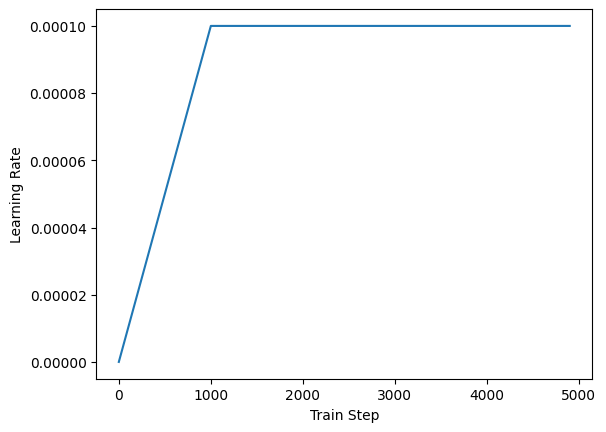

In [18]:
class WarmupSchedule(keras.optimizers.schedules.LearningRateSchedule):
    # We will make our own custom LearningRateSchedule with an eventual target learning rate of 1e-4.
    def __init__(self):
        self.rate = 1e-4
        self.warmup_steps = 1_000.

    # We start with something much smaller (1/1000 * our learning rate) and gradually increase toward 1e-4 over 1,000 steps.
    def __call__(self, step):
        step = ops.cast(step, dtype="float32")
        scale = ops.minimum(step / self.warmup_steps, 1.0)
        return self.rate * scale

import matplotlib.pyplot as plt

schedule = WarmupSchedule()
x  = range(0, 5_000, 100)
y = [schedule(step) for step in x]
plt.plot(x, y)
plt.xlabel("Train Step")
plt.ylabel("Learning Rate")
plt.savefig("learning-rate-warmup.png", dpi=300)

This code will take 2 hours to run on an A100... it might not run at all on a T4 (it might crash). This, despite that the model we are training has 1/3 the parameter count and 50x fewer training steps than GPT-1.

In [19]:
num_passes = 2
num_epochs = 16
steps_per_epoch = num_train_batches * num_passes // num_epochs

mini_gpt.compile(
    optimizer=keras.optimizers.Adam(schedule),

    # from_logits = True means that the softmax is not applied at output, it is actually applied inside the loss function.
    # There are technical reasons for doing this; it ends up being easier to do back propagation.
    # In particular, softmax clean result in probability values that require floating point precision that the computer cannot handle.
    # Using from_logits=True allows the softmax and cross-entropy calculations to be combined in a numerically stable way.
    # This avoids issues like underflow or overflow that can arise when computing softmax and log separately.
    # It also allows for more efficient computation, since TensorFlow can optimize the combined operation.
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),

    metrics=["accuracy"],
)

mini_gpt.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    # We are going to traverse the entire dataset only twice in total.
    # Each epoch will terminate early—after seeing only a subset of the data—
    # so that we can get intermediate updates on the loss and validation performance.
    steps_per_epoch=steps_per_epoch,
)

Epoch 1/16
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 835s 212ms/step - accuracy: 0.1103 - loss: 7.0366 - val_accuracy: 0.2152 - val_loss: 4.9261
Epoch 2/16


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3609/3609 ━━━━━━━━━━━━━━━━━━━━ 760s 211ms/step - accuracy: 0.2182 - loss: 4.8732 - val_accuracy: 0.2556 - val_loss: 4.4971
Epoch 3/16
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 762s 211ms/step - accuracy: 0.2554 - loss: 4.4981 - val_accuracy: 0.2882 - val_loss: 4.2240
Epoch 4/16
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 759s 210ms/step - accuracy: 0.2817 - loss: 4.2746 - val_accuracy: 0.3042 - val_loss: 4.0791
Epoch 5/16
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 760s 210ms/step - accuracy: 0.2955 - loss: 4.1467 - val_accuracy: 0.3132 - val_loss: 3.9879
Epoch 6/16
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 759s 210ms/step - accuracy: 0.3044 - loss: 4.0590 - val_accuracy: 0.3198 - val_loss: 3.9252
Epoch 7/16
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 760s 210ms/step - accuracy: 0.3097 - loss: 4.0049 - val_accuracy: 0.3249 - val_loss: 3.8727
Epoch 8/16
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 758s 210ms/step - accuracy: 0.3148 - loss: 3.9546 - val_accuracy: 0.3280 - val_loss: 3.8437
Epoch 9/16
3609/3609 ━━━━━━━━━━━━━━━━━━━━ 759s 210ms/step - accuracy: 0.3

Now we can generate text in response to a prompt...

In [20]:
def generate(prompt, max_length=64):
    tokens = list(tokenizer(prompt))
    prompt_length = len(tokens)
    for _ in range(max_length - prompt_length):
        prediction = mini_gpt(np.array([tokens]))
        prediction = prediction[0, -1]
        tokens.append(np.argmax(prediction).item())
    return tokenizer.detokenize(tokens)

prompt = "What is your favorite color?"
generate(prompt)

"What is your favorite color?\nI'm not sure what color is used in the color scheme, but I'm not sure what color is used in the color scheme.\nI'm not sure what color is used in the color scheme, but I'm not sure what color is used in the color"